# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from scripts.aoc_curves_data import aoc_curves_data
from scripts.aoc_curves_plot import aoc_curves_plot

## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

## Transformaciones necesarias al df

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [4]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]

In [5]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

(326, 6)

### ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [6]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---
# Función útil para graficar

In [7]:
def model_setup (model):
    model.fit(feat_train,targ_train)
    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))
    predicted = cross_val_predict(model,feat_train,targ_train,cv=10)
    print(classification_report(targ_train, predicted))
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

# Preparación de modelos y scores

In [8]:
modelos = [
    Perceptron(fit_intercept=False, max_iter=40000),
    Perceptron(fit_intercept=False, max_iter=40000,penalty="l2",random_state=420,alpha=1e-5,eta0=0.05),
    LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2),
    SVC(probability=True,gamma=0.61,C=0.85),
    RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.2),
    VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='hard'),
    VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='soft')
]
scores = []
for model in modelos:
    model.fit(feat_train,targ_train)
    scores.append(cross_val_score(model, feat_train, targ_train,cv=15, scoring=score_metric))


In [9]:
scores = pd.DataFrame(np.array(scores).T)
scores.columns = ["Per (BL)","Per_op","LR_op","SVC_op","RF_op","ADA_op","VotHard","VotSoft"]

In [10]:
meaned_scores = [0.657,0.711,0.801,0.877,0.865,0.781,0.871,0.862]

<BarContainer object of 8 artists>

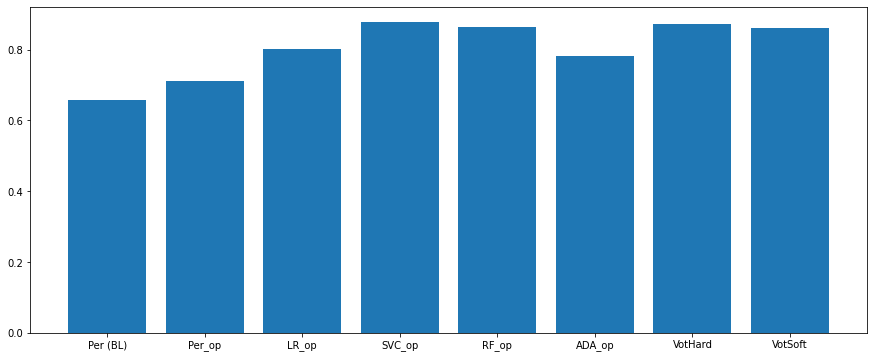

In [11]:
plt.figure(figsize=(15,6))
plt.bar(scores.columns,meaned_scores)

In [12]:
scores

,Per (BL),Per_op,LR_op,SVC_op,RF_op,ADA_op,VotHard,VotSoft
0,0.545455,0.545455,0.636364,0.818182,0.636364,0.636364,0.818182,0.818182
1,0.545455,0.363636,0.727273,0.909091,0.636364,0.909091,0.818182,0.818182
2,0.636364,0.363636,0.727273,0.818182,0.909091,0.545455,0.818182,0.818182
3,0.545455,0.454545,0.909091,0.909091,0.727273,0.727273,0.818182,0.818182
4,0.727273,0.727273,0.818182,0.818182,0.818182,0.727273,0.818182,0.818182
5,0.727273,0.727273,0.818182,0.818182,0.818182,0.727273,0.818182,0.818182
6,0.636364,0.727273,0.818182,0.818182,0.727273,0.727273,0.818182,0.818182
7,0.727273,0.818182,0.909091,0.909091,1.000000,0.909091,1.000000,1.000000
8,0.818182,0.727273,0.818182,0.818182,1.000000,1.000000,0.909091,0.909091
9,0.636364,0.727273,0.818182,1.000000,0.909091,0.909091,1.000000,1.000000


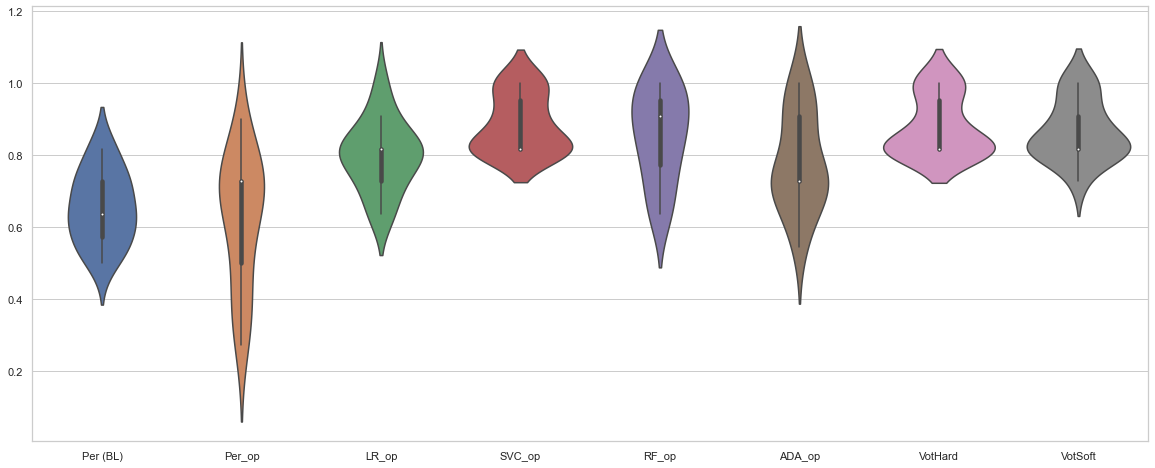

In [13]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,8))
sns.violinplot(data=scores)
plt.show()

---
# Gráficos AOC de ROC y PR

In [14]:
AOC_data = []

for model in modelos:
    try:
        (ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = aoc_curves_data(model,feat_train,targ_train)
        AOC_data.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, model))
    except:
        print(f"No se pudo analizar este modelo {model} 😅")

No se pudo analizar este modelo Perceptron(fit_intercept=False, max_iter=40000) 😅
No se pudo analizar este modelo Perceptron(alpha=1e-05, eta0=0.05, fit_intercept=False, max_iter=40000,
           penalty='l2', random_state=420) 😅
No se pudo analizar este modelo VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=2, fit_intercept=False,
                                                 max_iter=40000)),
                             ('tree',
                              RandomForestClassifier(min_impurity_decrease=0.0002,
                                                     n_estimators=400)),
                             ('svc',
                              SVC(C=0.85, gamma=0.61, probability=True))]) 😅


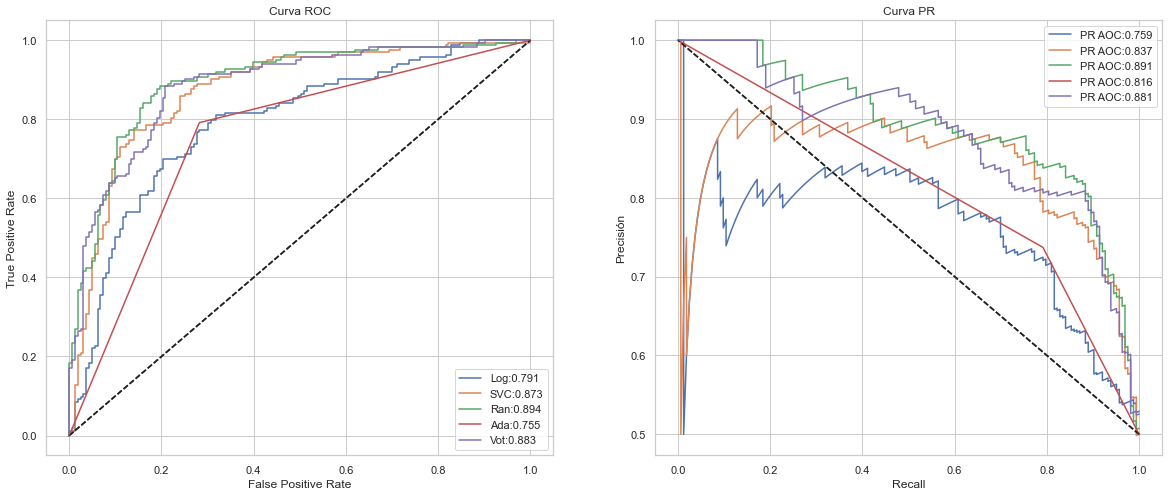

In [15]:
aoc_curves_plot(AOC_data)

---
---
---

# ADA BOOSTING

### Cambia levemente la metodologia, usa early stopping

In [16]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [17]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.52459	validation_1-error:0.42683
[11]	validation_0-error:0.18443	validation_1-error:0.29268
[12]	validation_0-error:0.15574	validation_1-error:0.29268
[13]	validation_0-error:0.11885	validation_1-error:0.26829
[14]	validation_0-error:0.10656	validation_1-error:0.28049
[15]	validation_0-error:0.10656	validation_1-error:0.26829
[16]	validation_0-error:0.10246	validation_1-error:0.26829
[17]	va

# RED NEURONAL SIMPLE

In [18]:
keras.backend.clear_session()

In [19]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 100)               700       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

Epoch 1/2000
9/9 [==============================] - 2s 59ms/step - loss: 0.6714 - recall: 0.1134 - val_loss: 0.7605 - val_recall: 0.3333
Epoch 2/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.6002 - recall: 0.4433 - val_loss: 0.7044 - val_recall: 0.5000
Epoch 3/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.5680 - recall: 0.6289 - val_loss: 0.6771 - val_recall: 0.5909
Epoch 4/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.5424 - recall: 0.6392 - val_loss: 0.6755 - val_recall: 0.6212
Epoch 5/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.5273 - recall: 0.6392 - val_loss: 0.6987 - val_recall: 0.6061
Epoch 6/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.5124 - recall: 0.5876 - val_loss: 0.7558 - val_recall: 0.5152
Epoch 7/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.5049 - recall: 0.5670 - val_loss: 0.7743 - val_recall: 0.5303
Epoch 8/2000
9/9 [=============================

Epoch 61/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.3058 - recall: 0.8660 - val_loss: 0.4887 - val_recall: 0.7879
Epoch 62/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.3078 - recall: 0.8041 - val_loss: 0.5481 - val_recall: 0.7727
Epoch 63/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.3009 - recall: 0.8247 - val_loss: 0.4805 - val_recall: 0.7727
Epoch 64/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.2946 - recall: 0.8454 - val_loss: 0.4819 - val_recall: 0.7727
Epoch 65/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.2920 - recall: 0.8351 - val_loss: 0.4908 - val_recall: 0.7727
Epoch 66/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.2890 - recall: 0.8660 - val_loss: 0.4111 - val_recall: 0.8182
Epoch 67/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.3026 - recall: 0.8557 - val_loss: 0.4624 - val_recall: 0.7879
Epoch 68/2000
9/9 [======================

9/9 [==============================] - 0s 9ms/step - loss: 0.1732 - recall: 0.9072 - val_loss: 0.3125 - val_recall: 0.8485
Epoch 121/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.1706 - recall: 0.8969 - val_loss: 0.3343 - val_recall: 0.8485
Epoch 122/2000
9/9 [==============================] - 0s 7ms/step - loss: 0.1672 - recall: 0.9072 - val_loss: 0.3109 - val_recall: 0.8788
Epoch 123/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.1672 - recall: 0.9072 - val_loss: 0.3017 - val_recall: 0.8636
Epoch 124/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.1622 - recall: 0.9072 - val_loss: 0.3121 - val_recall: 0.8636
Epoch 125/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.1603 - recall: 0.9072 - val_loss: 0.3058 - val_recall: 0.8636
Epoch 126/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.1608 - recall: 0.9072 - val_loss: 0.3140 - val_recall: 0.8636
Epoch 127/2000
9/9 [============================

9/9 [==============================] - 0s 9ms/step - loss: 0.0994 - recall: 0.9588 - val_loss: 0.2603 - val_recall: 0.9242
Epoch 180/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0927 - recall: 0.9794 - val_loss: 0.2045 - val_recall: 0.9394
Epoch 181/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0919 - recall: 0.9588 - val_loss: 0.2911 - val_recall: 0.8485
Epoch 182/2000
9/9 [==============================] - 0s 7ms/step - loss: 0.0900 - recall: 0.9485 - val_loss: 0.2407 - val_recall: 0.8939
Epoch 183/2000
9/9 [==============================] - 0s 7ms/step - loss: 0.0859 - recall: 0.9588 - val_loss: 0.2043 - val_recall: 0.9091
Epoch 184/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0862 - recall: 0.9794 - val_loss: 0.1969 - val_recall: 0.9394
Epoch 185/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0827 - recall: 0.9794 - val_loss: 0.2227 - val_recall: 0.9091
Epoch 186/2000
9/9 [=============================

9/9 [==============================] - 0s 8ms/step - loss: 0.0471 - recall: 0.9897 - val_loss: 0.1737 - val_recall: 0.9545
Epoch 239/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0457 - recall: 0.9897 - val_loss: 0.1803 - val_recall: 0.9545
Epoch 240/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0456 - recall: 0.9897 - val_loss: 0.1882 - val_recall: 0.9394
Epoch 241/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0449 - recall: 0.9897 - val_loss: 0.1790 - val_recall: 0.9545
Epoch 242/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0481 - recall: 0.9691 - val_loss: 0.2093 - val_recall: 0.9091
Epoch 243/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0451 - recall: 0.9897 - val_loss: 0.1505 - val_recall: 0.9545
Epoch 244/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0435 - recall: 0.9897 - val_loss: 0.1649 - val_recall: 0.9545
Epoch 245/2000
9/9 [=============================

9/9 [==============================] - 0s 10ms/step - loss: 0.0256 - recall: 0.9897 - val_loss: 0.1675 - val_recall: 0.9242
Epoch 298/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0240 - recall: 0.9897 - val_loss: 0.1470 - val_recall: 0.9394
Epoch 299/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0233 - recall: 1.0000 - val_loss: 0.1537 - val_recall: 0.9394
Epoch 300/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0235 - recall: 1.0000 - val_loss: 0.1487 - val_recall: 0.9394
Epoch 301/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0224 - recall: 1.0000 - val_loss: 0.1577 - val_recall: 0.9394
Epoch 302/2000
9/9 [==============================] - 0s 7ms/step - loss: 0.0223 - recall: 1.0000 - val_loss: 0.1376 - val_recall: 0.9545
Epoch 303/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0221 - recall: 1.0000 - val_loss: 0.1454 - val_recall: 0.9545
Epoch 304/2000
9/9 [==========================

9/9 [==============================] - 0s 9ms/step - loss: 0.0130 - recall: 1.0000 - val_loss: 0.1194 - val_recall: 0.9545
Epoch 357/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0129 - recall: 1.0000 - val_loss: 0.1386 - val_recall: 0.9394
Epoch 358/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0125 - recall: 1.0000 - val_loss: 0.1448 - val_recall: 0.9545
Epoch 359/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0126 - recall: 1.0000 - val_loss: 0.1391 - val_recall: 0.9545
Epoch 360/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0125 - recall: 1.0000 - val_loss: 0.1283 - val_recall: 0.9545
Epoch 361/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0119 - recall: 1.0000 - val_loss: 0.1452 - val_recall: 0.9394
Epoch 362/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0125 - recall: 1.0000 - val_loss: 0.1491 - val_recall: 0.9394
Epoch 363/2000
9/9 [==========================

9/9 [==============================] - 0s 13ms/step - loss: 0.0070 - recall: 1.0000 - val_loss: 0.1413 - val_recall: 0.9545
Epoch 416/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.0069 - recall: 1.0000 - val_loss: 0.1410 - val_recall: 0.9545
Epoch 417/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0069 - recall: 1.0000 - val_loss: 0.1373 - val_recall: 0.9545
Epoch 418/2000
9/9 [==============================] - ETA: 0s - loss: 0.0030 - recall: 1.00 - 0s 7ms/step - loss: 0.0069 - recall: 1.0000 - val_loss: 0.1478 - val_recall: 0.9545
Epoch 419/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0075 - recall: 1.0000 - val_loss: 0.1613 - val_recall: 0.9394
Epoch 420/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0074 - recall: 1.0000 - val_loss: 0.1229 - val_recall: 0.9545
Epoch 421/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0069 - recall: 1.0000 - val_loss: 0.1537 - val_recall: 0.9394
Epoch 

9/9 [==============================] - 0s 8ms/step - loss: 0.0048 - recall: 1.0000 - val_loss: 0.1467 - val_recall: 0.9545
Epoch 475/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0043 - recall: 1.0000 - val_loss: 0.1264 - val_recall: 0.9545
Epoch 476/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0045 - recall: 1.0000 - val_loss: 0.1395 - val_recall: 0.9545
Epoch 477/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0044 - recall: 1.0000 - val_loss: 0.1659 - val_recall: 0.9394
Epoch 478/2000
9/9 [==============================] - 0s 8ms/step - loss: 0.0050 - recall: 1.0000 - val_loss: 0.1230 - val_recall: 0.9545
Epoch 479/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0046 - recall: 1.0000 - val_loss: 0.1511 - val_recall: 0.9545
Epoch 480/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0043 - recall: 1.0000 - val_loss: 0.1448 - val_recall: 0.9545
Epoch 481/2000
9/9 [=============================

In [22]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 4ms/step - loss: 0.0288 - recall: 0.9877


[0.02880246192216873, 0.987730085849762]

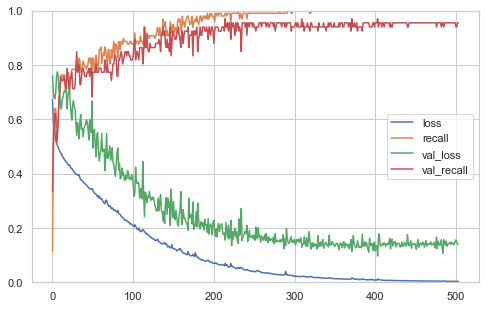

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

(array([158.,   5.,   1.,   0.,   1.,   1.,   2.,   0.,   2., 156.]),
 array([6.0323089e-09, 1.0000001e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

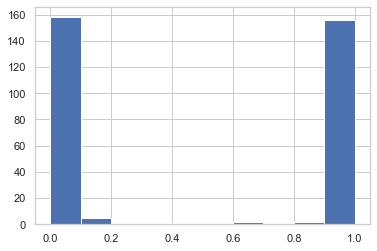

In [24]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

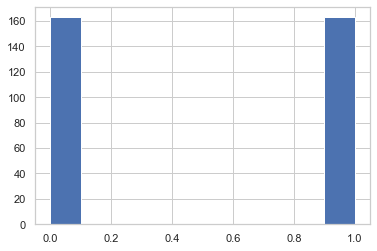

In [25]:
plt.hist(targ_train)

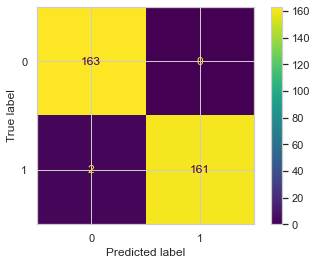

In [26]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()